# Import

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random
import transformers


c:\Users\Filippo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Seed

In [3]:
def set_seed(seed_value):
    """Imposta seed per riproducibilità."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)
transformers.set_seed(42)

ImportError: Traceback (most recent call last):
  File "c:\Users\Filippo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Routine di inizializzazione della libreria di collegamento dinamico (DLL) non riuscita.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

# HyperParameters

In [4]:
# MODEL NAMES LIST:
        # distilbert-base-uncased 
        # bert-base-uncased
        # roberta-base
        # xlm-roberta-large
        # bert-base-multilingual-cased
        # google/rembert
        # microsoft/deberta-base
        # microsoft/deberta-large
        # albert-base-v1
#xlm-roberta-base
MODEL_NAME = "roberta-base"

In [ ]:
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 1e-5
MAX_LENGTH = 256


In [18]:
TRAIN_PATH = "./dataset/train.csv"
#TRAIN_PATH = "train_simo.csv"
VAL_PATH = "./dataset/valid.csv"

# Data


In [19]:
def prepare_input(example):
    name = example.get("name", "")
    short_desc = example.get("description", "")
    full_desc = example.get("long_description", "")
    num_languages = example.get("num_languages", 0)
    num_languages = example.get("num_languages", 0)
    category,subcategory = example.get("category", ""), example.get("subcategory", "")
    # Convert to meaningful buckets
    if num_languages == 1:
        language_info = "This item is described in only one language."
    elif 2 <= num_languages <= 5:
        language_info = "This item is described in a few languages."
    elif 6 <= num_languages <= 20:
        language_info = "This item is described in many languages."
    elif 21 <= num_languages <= 50:
        language_info = "This item is described in numerous languages."
    else:
        language_info = "This item is described in a very large number of languages."
    
    input_text = (
        f"Name: {name}. "
       # f"Short description: {short_desc}. "
        f"Full description: {full_desc}. "
        f"ITEM CATEGORY: {category}. "
        f"ITEM SUBCATEGORY: {subcategory}. "
        f"{language_info}"
    )
    return input_text

In [20]:
class CulturalItemDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = prepare_input(row)
        label = row['label']  # Assumo che la colonna target sia 'label'

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [21]:
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
label_mapping = {
    'cultural agnostic': 0,
    'cultural representative': 1,
    'cultural exclusive': 2
}

train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)


# Model:

In [22]:

pretrained_model_name = MODEL_NAME  # Puoi cambiare con roberta-base o altri encoder

In [23]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=3)  # 3 classi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

# Dataloaders

In [24]:
max_len = MAX_LENGTH
batch_size = BATCH_SIZE

train_dataset = CulturalItemDataset(train_df, tokenizer, max_len)
val_dataset = CulturalItemDataset(val_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Optimizer


In [25]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * 5  # es. 5 epoche
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


# Training

In [26]:
num_epochs = EPOCHS
best_val_f1 = 0

train_losses = []
train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = accuracy_score(all_labels, all_preds)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    train_metrics['accuracy'].append(train_acc)
    train_metrics['precision'].append(train_prec)
    train_metrics['recall'].append(train_rec)
    train_metrics['f1'].append(train_f1)

    # Validation
    model.eval()
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(batch['labels'].cpu().numpy())

    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='macro')

    val_metrics['accuracy'].append(val_acc)
    val_metrics['precision'].append(val_prec)
    val_metrics['recall'].append(val_rec)
    val_metrics['f1'].append(val_f1)

    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Train Precision: {train_prec:.4f} | Val Precision: {val_prec:.4f}")
    print(f"Train Recall: {train_rec:.4f} | Val Recall: {val_rec:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    # Save best model based on Validation F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")

print(f"\nBest Validation F1: {best_val_f1:.4f}")


Epoch 1/3


  1%|          | 4/391 [02:03<3:19:15, 30.89s/it]


KeyboardInterrupt: 

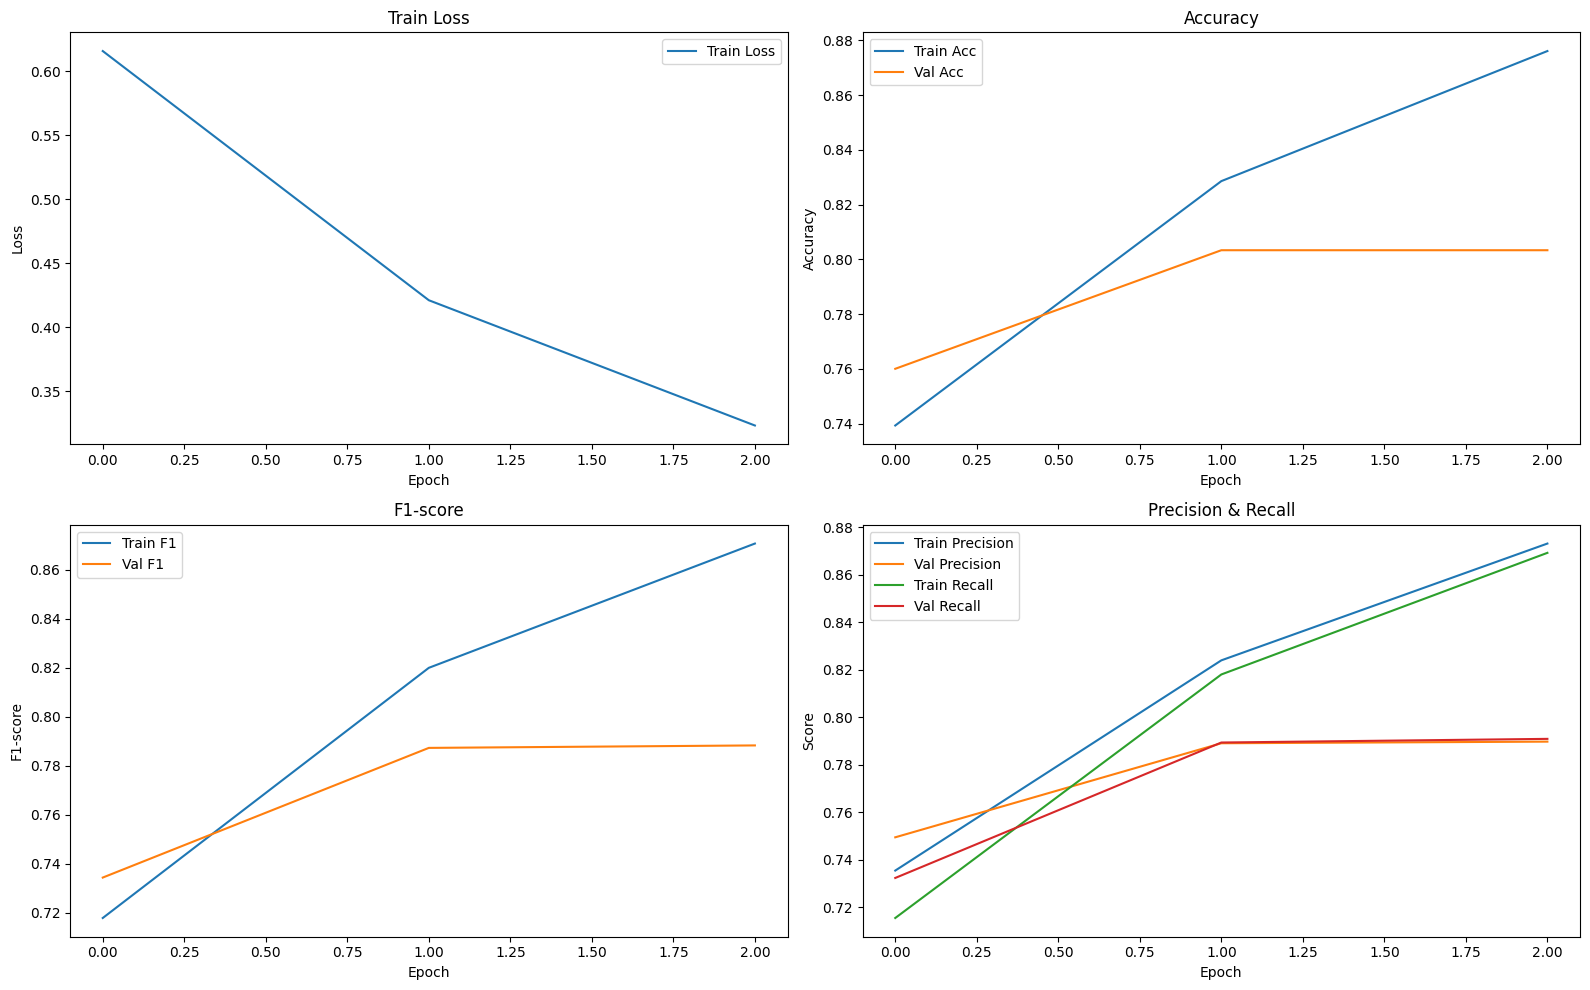

In [56]:
plt.figure(figsize=(16,10))

# Loss
plt.subplot(2,2,1)
plt.plot(train_losses, label='Train Loss')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(2,2,2)
plt.plot(train_metrics['accuracy'], label='Train Acc')
plt.plot(val_metrics['accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# F1-score
plt.subplot(2,2,3)
plt.plot(train_metrics['f1'], label='Train F1')
plt.plot(val_metrics['f1'], label='Val F1')
plt.title("F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()

# Precision-Recall
plt.subplot(2,2,4)
plt.plot(train_metrics['precision'], label='Train Precision')
plt.plot(val_metrics['precision'], label='Val Precision')
plt.plot(train_metrics['recall'], label='Train Recall')
plt.plot(val_metrics['recall'], label='Val Recall')
plt.title("Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()
